## <center>Title: Case Study 2<center>
## <center>Author: Paolo Ferrari<center>
## <center>Date: 2023-05-03<center>
    
---

### 1. Introduction

Combining geographical and social information with criminal data is an important component in predicting,
diagnosing, and explaining criminal activity in communities, cities or even states. Thus, the statistical analysis of
combined geographical-criminal datasets is a valuable tool for designing social policies. 

In this Case Study, we analyzed the geographical data of the year 1960 for 47 different states in the USA to try to predict their Crime Rates (number of offenses per 100,000 inhabitants) using Multivariate Linear Regression. 

To achieve this goal, we have fitted and compared the performance of 4 different models using different variable selection criteria: with AIC criterion, with BIC criterion, PCA regression and Lasso regression.

---

### 2. Data Overview



First, let's import the R libraries as well as the data and take a first look at it:

In [1]:
# Import libraries
library(leaps)
library(pls)
library(glmnet)
library(repr)
library(ggplot2)

# Read data into dataframe and transform it to numetic
data = read.table("uscrime.txt")
colnames(data) = c(data[1,])
data = data[-1,]
data[] = lapply(data, as.numeric)

head(data)


Attaching package: 'pls'


The following object is masked from 'package:stats':

    loadings


Loading required package: Matrix

Loaded glmnet 4.1-4

Warning message:
"package 'repr' was built under R version 4.2.3"


,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
3,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
4,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
5,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
6,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
7,12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682


The dataset has 47 rows and 16 columns, each row corresponding to a state in the US for the year of 1960. The last column, named Crime, is the variable we are trying to predict using the other 15. To get an initial picture of how
the data looks like, we plot in the next figure the scatter plots of the Crime Rate versus each of the other variables. 


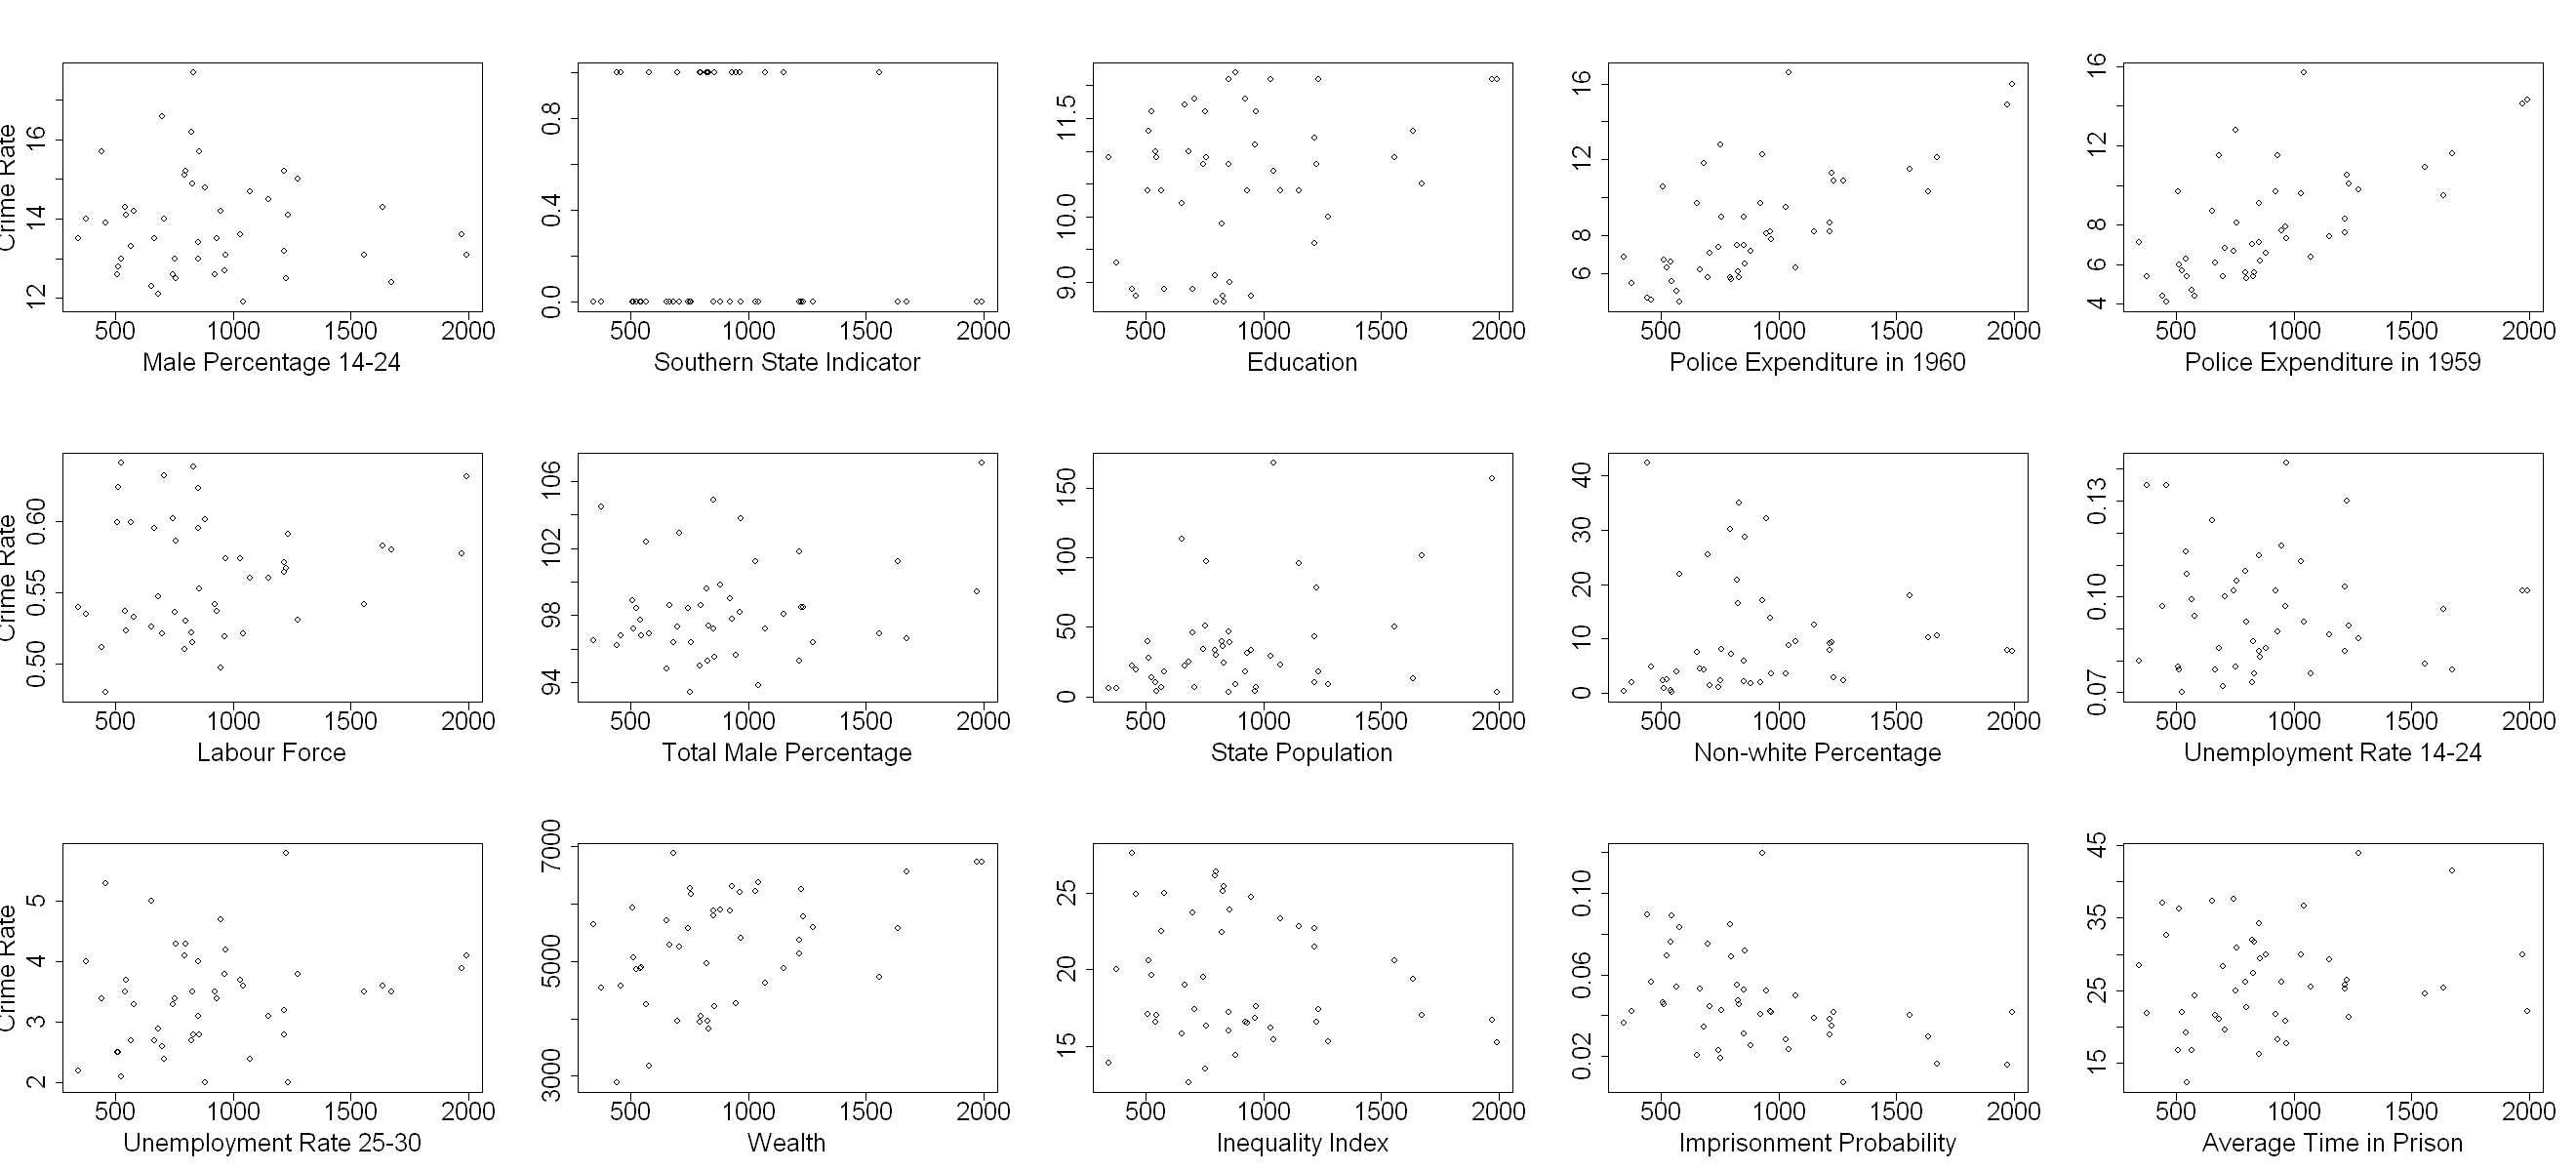

In [3]:
scale = 2

layout(matrix(c(1:15), nrow = 3, ncol = 5, byrow = TRUE))
plot(data$Crime, data$M,  xlab = "Male Percentage 14-24", ylab = "Crime Rate",cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$So, xlab = "Southern State Indicator", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Ed, xlab = "Education", ylab = "",cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Po1, xlab = "Police Expenditure in 1960", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Po2, xlab = "Police Expenditure in 1959", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$LF, xlab = "Labour Force", ylab = "Crime Rate",cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$M.F, xlab = "Total Male Percentage", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Pop, xlab = "State Population", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$NW, xlab = "Non-white Percentage", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$U1, xlab = "Unemployment Rate 14-24", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$U2, xlab = "Unemployment Rate 25-30", ylab = "Crime Rate", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Wealth, xlab = "Wealth", ylab = "",cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Ineq, xlab = "Inequality Index", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Prob, xlab = "Imprisonment Probability", ylab = "", cex.lab=scale, cex.axis = scale)
plot(data$Crime, data$Time, xlab = "Average Time in Prison", ylab = "", cex.lab=scale, cex.axis = scale)

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

fig(22,10)

First, we can see that there is a lot of variation in most of the scatterplots and that it is difficult to see a trend in most cases. Overall, the correlations with Crime Rate seem to be positive, although very weak. However, it is in fact possible
to see a good correlation with some of the variables, notably the Police Expenditures in 1960 and 1959, the
Unemployment Rates (classified between age group in years) and the Wealth (representing the median value of
transferable assets or family income). While these conclusions are mostly visual, they offer a hint to the number of
variables that should be included in the model selection algorithms tested next: roughly, we expect that only half of
the variables or less will be relevant.

---

### 3. Data Analysis

To fit and evaluate the different models used in this Case Study, we first split the data roughly as 75% for training
and 25% for testing. Since the total number of entries is 47, that amounts to 36 samples for training and 11 samples
for testing. We use the command “set.seed(1)” before splitting the data for reproducibility.


In [4]:
# Set the seed for random splitting of the data
set.seed(1)

# Split data into 11 samples (~25%) for testing and 36 samples for training (~75%)
N_test = 11
N_train = dim(data)[1] - N_test
test_indices = sample(c(1:dim(data)[1]),N_test)
test_data = data[test_indices,]
train_data = data[-test_indices,]

After preparing the data, we fit 4 different models using the train data according to different selection criteria:
AIC, BIC, PCA and Lasso. After the 4 models are found, we compare their performance on the test data.


**3.1 AIC and BIC** **models**

The first 2 models are found using the AIC and BIC criteria for variable selection from the full Multiple Linear
Regression model. For that, we use the Leaps and Bounds algorithm to detect which of the predictors should be included. 


In [7]:
# Define models and check their summary
model.part1 = regsubsets(Crime~., data = train_data, nvmax = 12)
summ.part1 = summary(model.part1)
summ.part1

Subset selection object
Call: regsubsets.formula(Crime ~ ., data = train_data, nvmax = 12)
15 Variables  (and intercept)
       Forced in Forced out
M          FALSE      FALSE
So         FALSE      FALSE
Ed         FALSE      FALSE
Po1        FALSE      FALSE
Po2        FALSE      FALSE
LF         FALSE      FALSE
M.F        FALSE      FALSE
Pop        FALSE      FALSE
NW         FALSE      FALSE
U1         FALSE      FALSE
U2         FALSE      FALSE
Wealth     FALSE      FALSE
Ineq       FALSE      FALSE
Prob       FALSE      FALSE
Time       FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: exhaustive
          M   So  Ed  Po1 Po2 LF  M.F Pop NW  U1  U2  Wealth Ineq Prob Time
1  ( 1 )  " " " " " " "*" " " " " " " " " " " " " " " " "    " "  " "  " " 
2  ( 1 )  " " " " " " "*" " " " " " " " " " " " " " " " "    "*"  " "  " " 
3  ( 1 )  " " " " " " "*" " " " " "*" " " " " " " " " " "    "*"  " "  " " 
4  ( 1 )  " " "*" " " "*" "*" " " "*" " " " " " " " " " "    " 

Check the AIC's and BIC's of the 12 selected models

In [8]:
sizes = 1:15

# Manual computation for AICs and BICs
AICs = N_train*log(summ.part1$rss/N_train) + 2*sizes
BICs = N_train*log(summ.part1$rss/N_train) + sizes*log(N_train)

# Show AIC and BIC values
print("AICs")
AICs
print("BICs")
BICs

# Find minimum AIC and BIC
cat("Model with lowest AIC:",which.min(AICs), "\n")
cat("Model with lowest BIC:",which.min(BICs))

Warning message in N_train * log(summ.part1$rss/N_train) + 2 * sizes:
"longer object length is not a multiple of shorter object length"
Warning message in N_train * log(summ.part1$rss/N_train) + sizes * log(N_train):
"longer object length is not a multiple of shorter object length"


[1] "AICs"


[1] 405.7024 400.6600 393.2983 392.1653 391.3651 391.1406 390.4926 389.2841
 [9] 389.2252 390.1088 390.8734 392.1642 429.7024 424.6600 417.2983

[1] "BICs"


[1] 407.2859 403.8271 398.0488 398.4994 399.2827 400.6417 401.5772 401.9523
 [9] 403.4769 405.9440 408.2921 411.1664 450.2881 446.8293 441.0511

Model with lowest AIC: 9 
Model with lowest BIC: 3

**Thus, the best AIC model is the model with 9 predictors (Model 9); whereas the best model according to BIC is the one with 3 predictors (Model 3).**

From the Table a couple cells above, we can see what are the variables included in Model 9 and 3. Below, we construct these 2 models:

In [9]:
# Define final AIC model
model.aic = lm(Crime ~ M + Ed + Po1 + M.F + U1 + U2 + Ineq + Prob, data = train_data )

# Similarly for final BIC model
model.bic = lm(Crime ~Po1 + M.F + Ineq, data = train_data )

**3.2: PCA model**

PCA, or PCR, refers to transforming the predictors from their original format to their principal components, followed
by a Multilinear Regression of the response variable with respect to these principal components. The idea is to try
to explain the variation of the response from combined variations of multiple predictor variables, thus avoid
collinearity issues.

In order to select how many principal components should be considered for the model, we have performed a crossvalidation (CV) of the train data and have chosen the number of components with minimum mean squared prediction
error across all folds. The number of folds for CV was 6, meaning that the train data (with 36 entries) was sliced in 6
parts, thus with 6 entries each. At each iteration, the model is trained in 5 of the 6 parts and the prediction error is
computed on the remaining one.

In [10]:
# Compute models using CV with 6 folds
model.pca = pcr(Crime~., data = train_data, validation = "CV", ncomp = 15, nfolds = 6)

# Compute mean validation error
PCA_error = RMSEP(model.pca, estimate = "CV")

# Check number of components with smallest error
N_PCA = which.min(PCA_error$val) - 1

N_PCA

[1] 8

**Thus, the model with minimum cross-validation prediction error has 8 components (+ the intercept).**

**3.3: Lasso model**

Lasso is a regularization technique which penalizes Linear Regression Models with large coefficients by adding a term proportional to the $L^1$ norm of the coefficients vector to the cost function. In order to fit a Lasso model, the proportionality constant $\lambda$ needs to be specified. In general, the value of $\lambda$ is obtained through
cross-validation.

In R, we use the “glmnet” package to fit a Lasso regression while also performing a cross-validation. Just like for PCA,
we use a 6-fold CV procedure to find the optimal λ.

In [11]:

# Prepare data for the Lasso algorithm
X = as.matrix(train_data[,-16])
Y = as.vector(train_data[,16])

# Compute Lasso models with 6-fold CV
model.lasso = cv.glmnet(X, Y, alpha = 1, nfolds = 6)

# Find the lambda of the model with minimum CV prediction error
lambda = model.lasso$lambda.min

lambda

[1] 31.91642

**Thus, the model with minimum cross-validation prediction error has a lambda of 31.9.** As an illustration, the next plot shows the Mean Squared Errors and their standard deviations from the 6 folds of the CV for each value of $log(\lambda)$. The minimum happens at $log(\lambda) \approx 3.45$ or $\lambda \approx 32$.

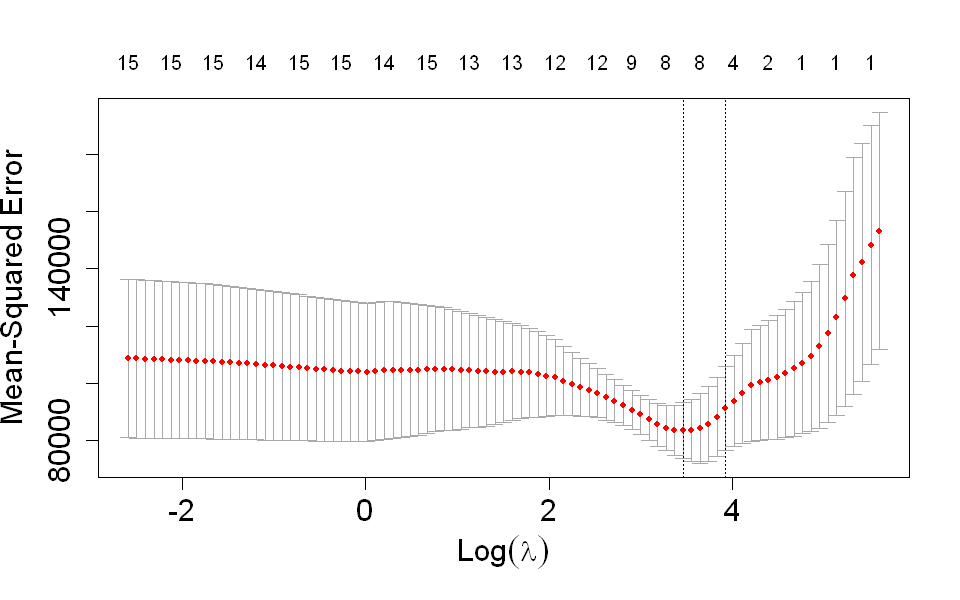

In [13]:
plot(model.lasso,cex.lab=1.5, cex.axis =1.5)
fig(8,5)


**Part 5: Predictions for the test data**

Finally, to select the best model out of the 4, we computed the MSE for each one using the test data. The next cell's output shows the results.

In [14]:
# Compute predictions of each model
pred_AIC = predict(model.aic, test_data[,-16])
pred_BIC = predict(model.bic, test_data[,-16])
pred_PCA = predict(model.pca, test_data[,-16], ncomp= N_PCA)
pred_lasso = predict(model.lasso, newx = as.matrix(test_data[,-16]), s = lambda)

# Compute mean square prediction error of the test data
TestMSE = c(sum((pred_AIC-test_data[,16])^2)/N_test,
           sum((pred_BIC-test_data[,16])^2)/N_test,
           sum((pred_PCA-test_data[,16])^2)/N_test,
           sum((pred_lasso-test_data[,16])^2)/N_test)

ModelCriterion = c('AIC', "BIC", "PCA", "Lasso")
df = data.frame(ModelCriterion, TestMSE)
print(df)

  ModelCriterion  TestMSE
1            AIC 33804.57
2            BIC 71578.96
3            PCA 67222.03
4          Lasso 83333.46


**Based on this table, we conclude that the model chosen from the AIC critetion has considerably lower error than
the others and thus is the model of choice of our analysis.**

For sake of clarity, we write here the final model:

$$
y = \beta_0 + \sum_{i=1}^9 \beta_1 X_i
$$

Where y is the Crime Rate (number of offenses per 100,000 inhabitants) and predictors $X_i$ from $i=1$ to 9 are

(1) Percentage of Males aged 14- 24

(2) Mean Years of Schooling

(3) Police Expenditure in 1960

(4) Police Expenditure in 1959

(5) Number of Males per 100 Females

(6) Unemployment Rate for Males aged 14-24

(7) Unemployment Rate for Males aged 35-39

(8) Income Inequality

(9) Probability of Imprisonment.


### Conclusion


In this study, we combined criminal and geographical data of 47 states in the US of the year 1960. We
concluded that the Crime Rates in that year (number of offenses per 100,000 inhabitants) are mostly related to 9 different
factors. In basic terms, these factors reflect the percentage of young males in the population, the mean years of
schooling of the population, the ratio between males and females, the expenditures with police, the unemployment
rate, the inequality of income and the ratio of prison commitments to offenses.
